In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from lifelines import KaplanMeierFitter
import glob

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [22]:
df_ord_orig = pd.read_csv('../data/order_churn_data.csv')
df_cus_orig = pd.read_csv('../data/churn_dataset.csv')

In [23]:
# limit dataset to customers who came after 2017
cust_ids = df_cus_orig.loc[df_cus_orig.first_order_created_datetime >= "2017-01-01"].customer_db_id
print(len(cust_ids), '/',  len(df_cus_orig))

34869 / 68891


In [24]:
df_ord = df_ord_orig.loc[df_ord_orig.customer_db_id.isin(cust_ids)]
df_cus = df_cus_orig.loc[df_cus_orig.customer_db_id.isin(cust_ids)]
df_ord = df_ord.merge(df_cus[['customer_db_id', 'customer_id', 'completed_orders', 'last_order_created_datetime']], 
                      on=['customer_db_id', 'customer_id'], how='inner')
df_ord['days_since_last_seen'] = (datetime.now() - pd.to_datetime(df_ord.last_order_created_datetime)).dt.days

### Completed Dataset

In [25]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])
df_comp['order_created_datetime'] = pd.to_datetime(df_comp.order_created_datetime)

# completed orders
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days

df_comp = df_comp.drop(['next_order_date', 'last_order_date'], axis=1)

In [26]:
df_comp['first_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('min')
df_comp['last_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('max')
df_comp['lifetime'] = (df_comp.last_completed_order - df_comp.first_completed_order).dt.days
df_comp['first_completed_order_day'] = (df_comp.first_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['last_completed_order_day'] = (df_comp.last_completed_order - datetime(2017, 1, 1)).dt.days

In [27]:
df_comp.loc[df_comp.completed_orders < 2, 'frequency'] = 45

### How to define churn?
What is the distribution of time between orders?
- 75% of customers come back within 40 days for next order
- 95% of customers come back within 141 days for next order

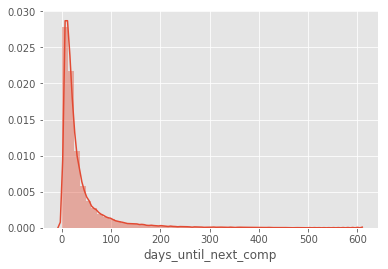

In [28]:
sns.distplot(df_comp.loc[~df_comp.days_until_next_comp.isnull(), 'days_until_next_comp'])

In [29]:
df_comp.days_until_next_comp.describe()

count    65966.000000
mean        37.422748
std         55.643496
min          0.000000
25%          9.000000
50%         19.000000
75%         40.000000
max        602.000000
Name: days_until_next_comp, dtype: float64

In [30]:
df_comp.days_until_next_order.quantile(.95)

141.0

# Survival Analysis
How much time do customers survive on the platform?
- days between last order and first order
- only for customers with more than one order completed

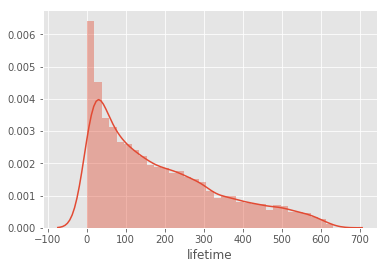

In [31]:
d = df_comp.loc[df_comp.completed_orders > 1, ['customer_db_id', 'completed_orders', 'lifetime']].drop_duplicates()
sns.distplot(d.lifetime)

Customer sample

In [32]:
df_survival = df_comp.loc[df_comp.completed_orders > 1]
df_survival = df_survival[['customer_db_id', 'lifetime', 'days_since_last_seen', 
                           'completed_orders', 'city', 'frequency']].drop_duplicates()

In [33]:
kmf = KaplanMeierFitter()

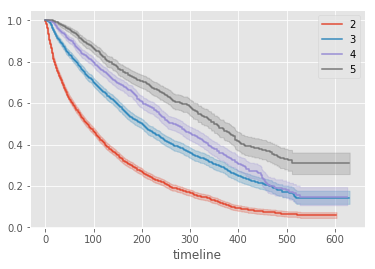

In [34]:
fig, ax = plt.subplots()
for c in range(2, 6):
    df_c = df_survival.loc[df_survival.completed_orders == c]
    kmf.fit(df_c.lifetime, df_c.days_since_last_seen > 140, label=str(c))
    kmf.plot(ax=ax)

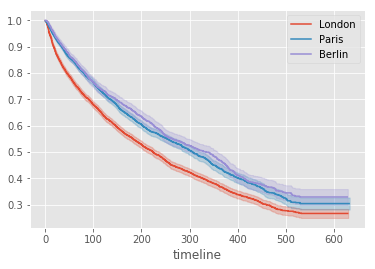

In [35]:
fig, ax = plt.subplots()
for c in df_survival.city.unique():
    df_c = df_survival.loc[df_survival.city == c]
    kmf.fit(df_c.lifetime, df_c.days_since_last_seen > 140, label=str(c))
    kmf.plot(ax=ax)

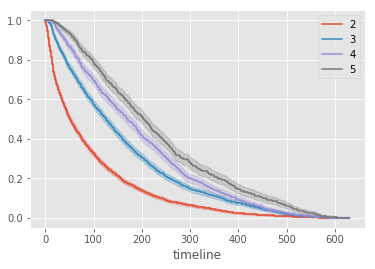

In [36]:
fig, ax = plt.subplots()
for c in range(2, 6):
    df_c = df_survival.loc[df_survival.completed_orders == c]
    kmf.fit(df_c.lifetime, df_c.days_since_last_seen > 45, label=str(c))
    kmf.plot(ax=ax)

# Braze Data

In [44]:
braze_camp = pd.read_csv('../data/braze_campaigns.csv')
braze_canv = pd.read_csv('../data/braze_canvases.csv')

In [38]:
df_cus.loc[(df_cus.completed_orders > 2) & (df_cus.customer_id.isin(braze_canv.customer_id))]

,email,customer_db_id,customer_id,gender,segment,aov,recency,frequency,churn_factor,referred,...,pickup_early_morning,pickup_evening,late_orders,early_orders,unpunctual_orders,unpunctual_ratio,laundry_distance,laundry_rating,laundry_within_1km,NPS
5,014651@gmail.com,58a0c160447709e4048b456d,CUS-X3525283,female,GREEN.DENSITY,26.269540,101,17.821429,5.667335,False,...,0.375000,0.218750,3.0,3.0,5.0,0.172414,1554.239470,3.5,0.0,NaN
23,100299353@qq.com,58c8c97f4577099e7e8b457f,CUS-S0523419,male,GREEN.DENSITY,21.658192,413,52.000000,7.942308,False,...,0.800000,0.000000,NaN,1.0,1.0,0.250000,1521.187141,3.3,0.0,NaN
24,1009561830@qq.com,594012f546770926778b4623,CUS-W-BL-41917841,male,GOLD,32.697932,77,36.545455,2.106965,False,...,0.538462,0.230769,1.0,4.0,2.0,0.166667,1668.086504,4.3,0.0,NaN
45,112kinggeorge@startuphome.io,58b4a4a6447709d6098b466d,CUS-W-ML-37303133,male,GOLD,49.240359,442,28.600000,15.454545,False,...,0.666667,0.166667,1.0,NaN,NaN,NaN,305.791241,3.8,1.0,NaN
54,1234@aol.com,58a1852f44770908228b4658,CUS-W-SH-32179963,male,GREEN.DENSITY,15.026751,73,105.200000,0.693916,False,...,0.666667,0.166667,NaN,NaN,NaN,NaN,438.358127,5.0,6.0,NaN
60,123@example.com,592d5b0e4577093d1c8b45f7,CUS-R0920771,male,GOLD,56.762399,433,12.000000,36.083333,False,...,0.833333,0.111111,2.0,NaN,2.0,0.333333,1172.122584,4.0,0.0,NaN
61,123@example.com,592d5b0e4577093d1c8b45f7,CUS-R0920771,male,GOLD,56.762399,433,12.000000,36.083333,False,...,0.833333,0.111111,2.0,NaN,2.0,0.333333,1172.122584,4.0,0.0,NaN
62,123@me.com,58dbbd4b447709107d8b458b,CUS-P1514525,male,BLACK,134.701879,389,11.066667,35.150602,False,...,0.481481,0.259259,NaN,NaN,NaN,NaN,707.767116,4.0,1.0,NaN
90,19gramschaussee@gmail.com,5a61d054457709204a8b4642,CUS-H1334669,female,GREEN.DENSITY,12.596639,207,7.428571,27.865385,False,...,1.000000,0.000000,1.0,1.0,2.0,0.250000,360.545595,4.5,1.0,NaN
105,1laurawitcher@gmail.com,59ada64a45770919548b46f3,CUS-P6470897,female,GREEN.DENSITY,24.465743,358,7.600000,47.105263,False,...,0.285714,0.714286,NaN,NaN,NaN,NaN,1188.714886,5.0,0.0,8.0


In [43]:
df_ord.loc[df_ord.customer_id == 'CUS-E6897829'].sort_values('order_created_datetime')

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,newsletter_optin,customer_id,email,corporate,referred,cluster,cluster_name,completed_orders,last_order_created_datetime,days_since_last_seen
98,DE-A-99799,5af89f3219207a104932d71f,5af89f35c343623c400fa1a9,52.48123,13.33091,2018-05-16 18:30:00,2018-05-16 19:30:00,10715,completed,2018-05-13 22:25:25,...,True,CUS-E6897829,michael.thiele@wangiro.de,False,False,7.0,Trousers+Shirt,3,2018-08-18 17:51:29,88
99,DE-H-42305,5af89f3219207a104932d71f,5b1237c6ee1b6a2ca8417eb3,52.48123,13.33091,2018-06-04 18:30:00,2018-06-04 19:30:00,10715,completed,2018-06-02 08:23:02,...,True,CUS-E6897829,michael.thiele@wangiro.de,False,False,7.0,Trousers+Shirt,3,2018-08-18 17:51:29,88
97,DE-A-00748,5af89f3219207a104932d71f,5b783dfec343625d52548560,NaN,NaN,2018-08-20 18:30:00,2018-08-20 19:30:00,10715,canceled,2018-08-18 17:40:46,...,True,CUS-E6897829,michael.thiele@wangiro.de,False,False,NaN,NaN,3,2018-08-18 17:51:29,88
100,DE-Y-42971,5af89f3219207a104932d71f,5b784081c343625d55484e50,52.48123,13.33091,2018-08-20 19:00:00,2018-08-20 20:00:00,10715,completed,2018-08-18 17:51:29,...,True,CUS-E6897829,michael.thiele@wangiro.de,False,False,7.0,Trousers+Shirt,3,2018-08-18 17:51:29,88


In [45]:
braze_canv.loc[braze_canv.customer_id == 'CUS-E6897829']

,customer_id,api_canvas_id,in_control,last_entered,last_exited,last_received_message,canvas_name,steps_received,variation_name,canvas_num,api_canvas_step_id,last_received,canvas_step_name,canvas_step_num
51020,CUS-E6897829,01ad4236-c2a4-4bb8-9bf5-e2ea27bc1690,False,2018-06-01T13:25:01.000Z,NaN,2018-06-15T13:25:04.353Z,DE_1st_Interaction_Mobile,[{'name': 'DE_1st_Interaction_Refer_A_Friend F...,DE_1st_Interaction_Refer_A_Friend,0,80cb5386-d392-40b2-b825-52975af29737,2018-06-01T13:25:04.714Z,DE_1st_Interaction_Refer_A_Friend First Step,0.0
51021,CUS-E6897829,01ad4236-c2a4-4bb8-9bf5-e2ea27bc1690,False,2018-06-01T13:25:01.000Z,NaN,2018-06-15T13:25:04.353Z,DE_1st_Interaction_Mobile,[{'name': 'DE_1st_Interaction_Refer_A_Friend F...,DE_1st_Interaction_Refer_A_Friend,0,dd67563b-efc2-4bb3-bdcd-965e7d69b512,2018-06-08T13:25:04.329Z,DE_1st_Interaction_Voucher,1.0
51022,CUS-E6897829,01ad4236-c2a4-4bb8-9bf5-e2ea27bc1690,False,2018-06-01T13:25:01.000Z,NaN,2018-06-15T13:25:04.353Z,DE_1st_Interaction_Mobile,[{'name': 'DE_1st_Interaction_Refer_A_Friend F...,DE_1st_Interaction_Refer_A_Friend,0,005bda53-630f-42f8-a004-0de8011130f2,2018-06-15T13:25:04.353Z,DE_1st_Interaction_Voucher_Reminder,2.0
51023,CUS-E6897829,bdf3d6de-2ec6-47ba-8680-67383bd13b2d,False,2018-06-29T15:45:00.000Z,NaN,NaN,DE_Prospective,[],Clone of Clone of Clone of DE_Prospective_Voucher,1,NaN,NaN,NaN,NaN
51024,CUS-E6897829,26594289-0d6e-497c-9a24-3cba1db7a856,False,2018-06-29T15:45:01.000Z,NaN,2018-07-14T15:45:05.476Z,DE_Prospective_Mobile,"[{'name': 'DE_Prospective_Voucher First Step',...",DE_Prospective_Voucher,2,9d2e430e-ae1e-408f-b225-9f189bd6461a,2018-06-29T15:45:05.688Z,DE_Prospective_Voucher First Step,0.0
51025,CUS-E6897829,26594289-0d6e-497c-9a24-3cba1db7a856,False,2018-06-29T15:45:01.000Z,NaN,2018-07-14T15:45:05.476Z,DE_Prospective_Mobile,"[{'name': 'DE_Prospective_Voucher First Step',...",DE_Prospective_Voucher,2,d100b180-ff64-4370-b12c-092870457e84,2018-07-07T15:45:05.441Z,DE_Prospective_Voucher_Reminder,1.0
51026,CUS-E6897829,26594289-0d6e-497c-9a24-3cba1db7a856,False,2018-06-29T15:45:01.000Z,NaN,2018-07-14T15:45:05.476Z,DE_Prospective_Mobile,"[{'name': 'DE_Prospective_Voucher First Step',...",DE_Prospective_Voucher,2,dc0bd634-d2e5-49b7-86ce-5c9d1a0960bd,2018-07-14T15:45:05.476Z,DE_Prospective_Voucher_Reminder 2,2.0
51027,CUS-E6897829,7708e41f-d386-4bb3-af40-d494d5b322aa,False,2018-07-27T12:30:02.000Z,2018-08-10T12:30:08.092Z,2018-08-10T12:30:08.092Z,DE_Dormant_Mobile,"[{'name': 'DE_Dormant_Voucher First Step', 'ap...",DE_Dormant_Voucher,3,67ec2853-62d9-4537-b1e6-fdd7c21c656a,2018-07-27T12:30:05.904Z,DE_Dormant_Voucher First Step,0.0
51028,CUS-E6897829,7708e41f-d386-4bb3-af40-d494d5b322aa,False,2018-07-27T12:30:02.000Z,2018-08-10T12:30:08.092Z,2018-08-10T12:30:08.092Z,DE_Dormant_Mobile,"[{'name': 'DE_Dormant_Voucher First Step', 'ap...",DE_Dormant_Voucher,3,542ae446-dae4-4337-b3ca-457e58773907,2018-08-03T12:30:06.463Z,DE_Dormant_Voucher_Reminder,1.0
51029,CUS-E6897829,7708e41f-d386-4bb3-af40-d494d5b322aa,False,2018-07-27T12:30:02.000Z,2018-08-10T12:30:08.092Z,2018-08-10T12:30:08.092Z,DE_Dormant_Mobile,"[{'name': 'DE_Dormant_Voucher First Step', 'ap...",DE_Dormant_Voucher,3,d889157d-ea52-4169-993d-57489d17ffb9,2018-08-10T12:30:08.092Z,DE_Dormant_Voucher_Reminder 3,2.0
